In [135]:
from PIL import Image
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [136]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("HIP version:", torch.version.hip)
print("Device count:", torch.cuda.device_count())
print("Device 0:", torch.cuda.get_device_name(0))

Using device: cuda
HIP version: 6.2.41133-dd7f95766
Device count: 1
Device 0: AMD Radeon RX 6800


In [137]:
class MyResnet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.backbone = resnet18(weights=None)
        self.backbone.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.backbone.maxpool = nn.Identity()
        self.backbone.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        return self.backbone(x)

In [138]:
net = MyResnet()
checkpoint = torch.load("trained_model.pth")
net.load_state_dict(checkpoint["model_state"])

/tmp/ipykernel_40100/749520413.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("trained_model.pth")


<All keys matched successfully>

In [139]:
transform_train = transforms.Compose([
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [140]:
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=16, pin_memory=True)

Files already downloaded and verified


In [141]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [142]:
correct = 0
total = 0

net = net.to(device)
net.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 95.10%


In [143]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

new_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = new_transform(image)
    image = image.unsqueeze(0)
    return image

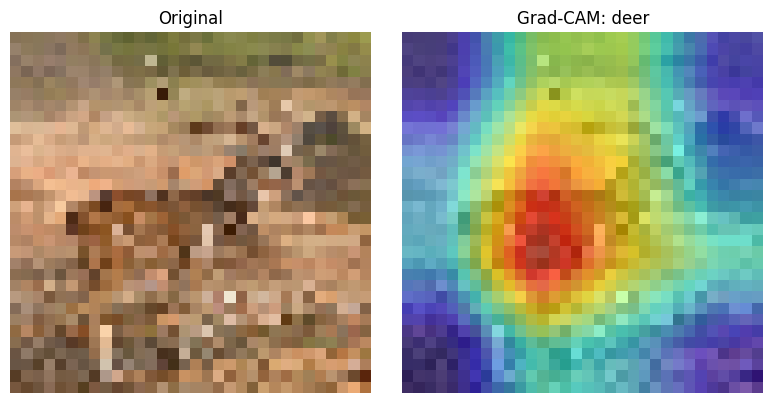

Obraz: data/tests/deer.jpg, Predykcja: deer


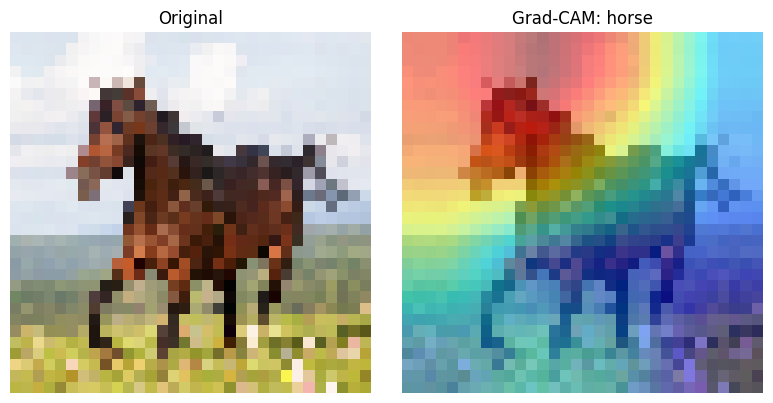

Obraz: data/tests/horse.jpg, Predykcja: horse


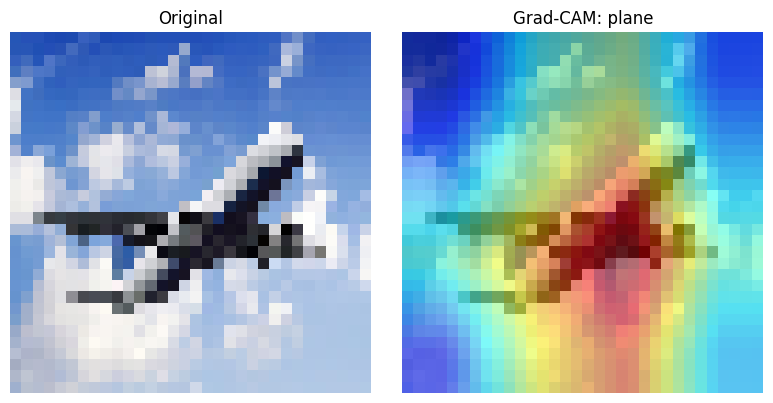

Obraz: data/tests/plane.jpg, Predykcja: plane


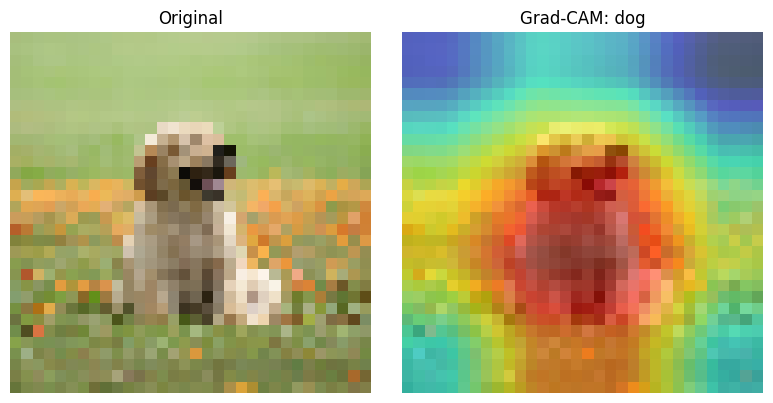

Obraz: data/tests/dog.jpg, Predykcja: dog


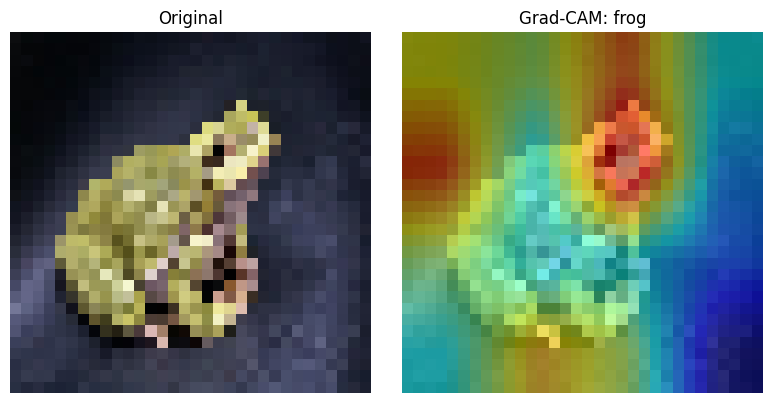

Obraz: data/tests/frog.jpg, Predykcja: frog


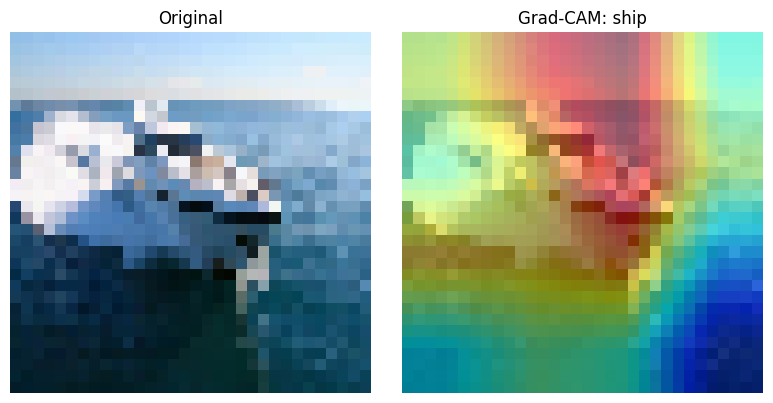

Obraz: data/tests/ship.jpg, Predykcja: ship


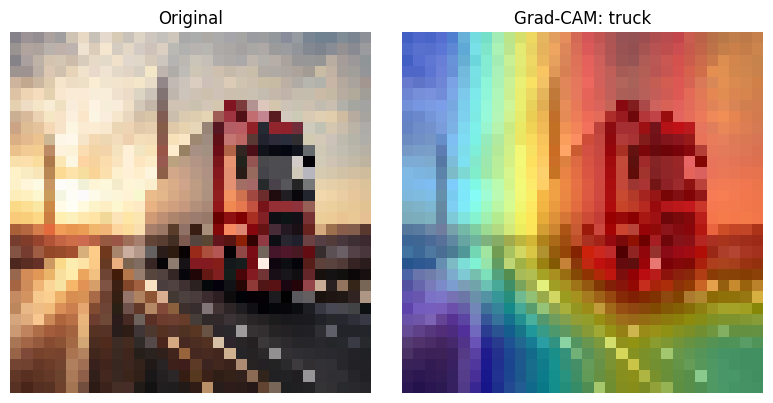

Obraz: data/tests/truck.jpg, Predykcja: truck


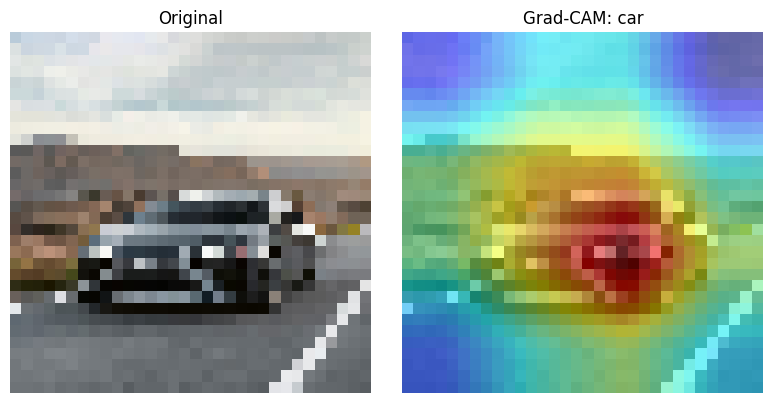

Obraz: data/tests/car.jpg, Predykcja: car


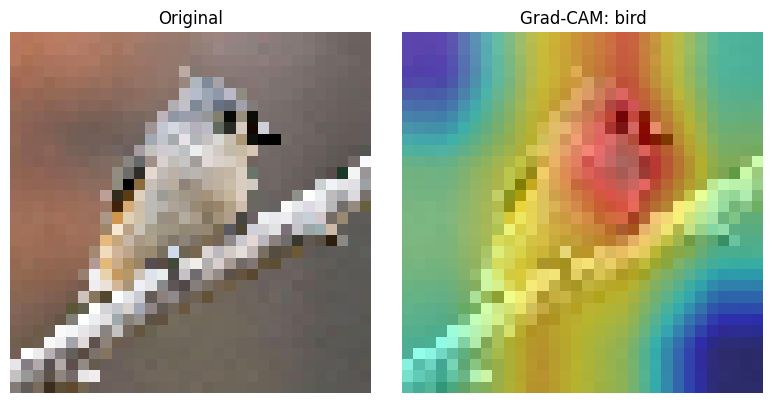

Obraz: data/tests/bird.jpg, Predykcja: bird


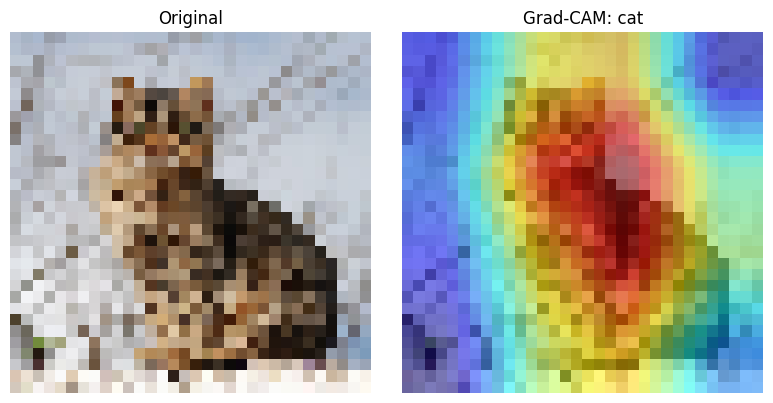

Obraz: data/tests/cat.jpg, Predykcja: cat


In [144]:
target_layers = [net.backbone.layer4[-1]]
cam = GradCAM(model=net, target_layers=target_layers)

def visualize_gradcam(image_path, model, transform, class_names):
    img_cv2 = cv2.imread(image_path)
    img_cv2 = cv2.resize(img_cv2, (32, 32))
    img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    img_normalized_for_vis = np.float32(img_rgb) / 255.0

    pil_img = Image.open(image_path).convert('RGB')
    input_tensor = transform(pil_img).unsqueeze(0).to(device)

    model.eval()
    outputs = model(input_tensor)
    _, predicted_idx = torch.max(outputs, 1)
    predicted_label = class_names[predicted_idx.item()]

    grayscale_cam = cam(input_tensor=input_tensor, targets=None)

    grayscale_cam = grayscale_cam[0, :]

    visualization = show_cam_on_image(img_normalized_for_vis, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title(f"Grad-CAM: {predicted_label}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    print(f"Obraz: {image_path}, Predykcja: {predicted_label}")



image_paths = os.listdir('data/tests')
image_paths = [os.path.join('data/tests/', img) for img in image_paths]

for path in image_paths:
    visualize_gradcam(path, net, new_transform, class_names)